In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv1D, MaxPooling2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, add, Cropping2D, ReLU, BatchNormalization, Lambda, PReLU
from tensorflow.keras.layers import Concatenate, Reshape, MaxPooling1D, Cropping1D, ZeroPadding1D, Flatten
from tensorflow.keras.layers import AveragePooling2D, LSTM, RepeatVector, TimeDistributed, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.utils import Sequence, OrderedEnqueuer
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import activations
from tensorflow.keras.backend import expand_dims, mean, clip, int_shape

import os
import re
import datetime
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt
import random

devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

In [2]:
height_x = 120
width_x = 120
channels = 3
shape_x = (height_x, width_x, channels)
width_y = 28
shape_y = (height_x, width_y, channels)

data_num = 2
data_dir = f"../../datasets/dataset_0{data_num}/quarter/"
name = "U2-net"

activation = 'relu'
regularizer = regularizers.l1(1e-9)
dropout_ratio = 0.25

batch_size = 32
epochs = 50
learning_rate = 1e-4

workers = 4
max_queue = 6

In [3]:
class DataGenerator(Sequence):

    def __init__(self, list_IDs, batch_size=4,
                    n_channels=1, n_classes=1, shuffle=True):
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = []
        for i in range(index*self.batch_size, (index+1)*self.batch_size):
            indexes.append(i)

        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, Ys = self.__data_generation(list_IDs_temp)
        return X, Ys

    def on_epoch_end(self):
        return 0

    def __data_generation(self, list_IDs_temp):
        Y = []
        X = []
        for i, filename in enumerate(list_IDs_temp):
            if re.search("\.(jpg|jpeg)", filename):
                filepath = os.path.join(data_dir, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                    flip = random.randint(0, 1)
                    if flip:
                        image = np.flip(image, axis=1)
                    crop = random.randint(0, 10)
                    image = image[:,crop:,:]
                    image_x = image[:,:120,:]
                    image_y = image[:,120:150,:]
                    Y.append(image_y)
                    X.append(image_x)
                    #print(f'X: {image_x.shape} | Y: {image_y.shape}\nCrop: {crop} | Image: {image.shape}')
                    
        Y = (1./255) * np.array(Y)
        X = (1./255) * np.array(X)

        Ys = [Y]
        og_size = Y.shape
        #print(og_size)
        for i in range(1, 4):
            Y_temp = []
            #print(Y.shape[0])
            for j in range(0, og_size[0]):
            #for j in range(0, len(list_IDs_temp)):
                Y_temp.append(resize(Y[j], (og_size[1]//(2*(2**(i-1))), og_size[2]//(2*(2**(i-1))))))
            Y_temp = np.array(Y_temp)
            Ys.append(Y_temp)
        Ys.append(Y)

        return X, Ys

### Test DataGen

(32, 60, 15, 3)
(32, 30, 7, 3)
(32, 15, 3, 3)


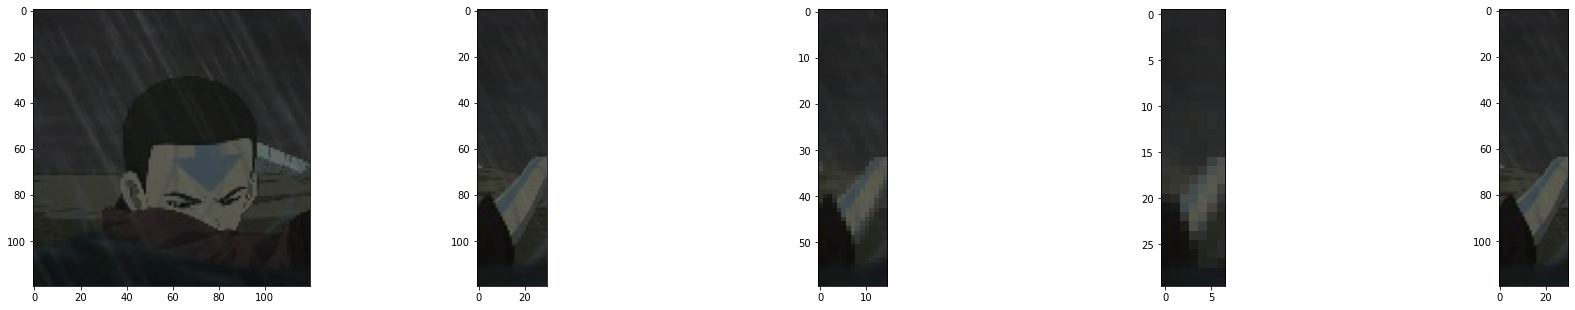

In [4]:
files = os.listdir(data_dir)
gen_loader = DataGenerator(files, batch_size=32)
X, Ys = gen_loader.__getitem__(0)
index = random.randint(0, 32)
print(Ys[1].shape)
print(Ys[2].shape)
print(Ys[3].shape)

plt.figure(figsize=(60, 60))
ax = plt.subplot(10, 10, 1)
plt.imshow(X[index])
ax = plt.subplot(10, 10, 2)
plt.imshow(Ys[0][index])
ax = plt.subplot(10, 10, 3)
plt.imshow(Ys[1][index])
ax = plt.subplot(10, 10, 4)
plt.imshow(Ys[2][index])
ax = plt.subplot(10, 10, 5)
plt.imshow(Ys[3][index])
ax = plt.subplot(10, 10, 5)
plt.imshow(Ys[4][index])

### Layers

In [4]:
def ResizeLayerLike(tensorA, tensorB):
    sB = int_shape(tensorB)
    def resize_like(tensor, sB): return tf.image.resize(tensor, sB[1:3])
    return Lambda(resize_like, arguments={'sB':sB})(tensorA)

def RebnConv(layer, filters, kernel=3, padding='same', dil=1):
    x = Conv2D(filters, kernel_size=kernel, padding=padding, dilation_rate=(dil,dil))(layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x

### Tanh

In [6]:
netname=''


input_x = Input(shape=shape_x)

x_1 = Lambda(lambda x: x[:,:,:30,:])(input_x)
x_2 = Lambda(lambda x: x[:,:,30:60,:])(input_x)
x_3 = Lambda(lambda x: x[:,:,60:90,:])(input_x)
x_4 = Lambda(lambda x: x[:,:,90:120,:])(input_x)
x = Concatenate(axis=3)([x_1,x_2,x_3,x_4])

# U2 Block #1

xh_in = RebnConv(x,64)
xh1 = RebnConv(xh_in,32)
xh = MaxPooling2D()(xh1)
xh2 = RebnConv(xh,32)
xh = MaxPooling2D()(xh2)
xh3 = RebnConv(xh,32)
xh = MaxPooling2D()(xh3)
xh4 = RebnConv(xh,32)
xh = MaxPooling2D()(xh4)

xh5 = RebnConv(xh,32)
xh6 = RebnConv(xh5,32, dil=2)

xh5d = RebnConv(Concatenate(axis=3)([xh5,xh6]), 32)
xh5dup = ResizeLayerLike(xh5d, xh4)
xh4d = RebnConv(Concatenate(axis=3)([xh5dup,xh4]), 32)
xh4dup = ResizeLayerLike(xh4d, xh3)
xh3d = RebnConv(Concatenate(axis=3)([xh4dup,xh3]), 32)
xh3dup = ResizeLayerLike(xh3d, xh2)
xh2d = RebnConv(Concatenate(axis=3)([xh3dup,xh2]), 32)
xh2dup = ResizeLayerLike(xh2d, xh1)
xh1d = RebnConv(Concatenate(axis=3)([xh2dup,xh1]), 64)

xh_out_1 = add([xh_in, xh1d])

# U2 Block #2

xh_in_2 = MaxPooling2D()(xh_out_1)
xh_in = RebnConv(xh_in_2,128)
xh1 = RebnConv(xh_in,32)
xh = MaxPooling2D()(xh1)
xh2 = RebnConv(xh,32)
xh = MaxPooling2D()(xh2)
xh3 = RebnConv(xh,32)
xh = MaxPooling2D()(xh3)

xh4 = RebnConv(xh,32)
xh5 = RebnConv(xh4,32, dil=2)

xh4d = RebnConv(Concatenate(axis=3)([xh4,xh5]), 32)
xh4dup = ResizeLayerLike(xh4d, xh3)
xh3d = RebnConv(Concatenate(axis=3)([xh4dup,xh3]), 32)
xh3dup = ResizeLayerLike(xh3d, xh2)
xh2d = RebnConv(Concatenate(axis=3)([xh3dup,xh2]), 32)
xh2dup = ResizeLayerLike(xh2d, xh1)
xh1d = RebnConv(Concatenate(axis=3)([xh2dup,xh1]), 128)

xh_out_2 = add([xh_in, xh1d])

# U2 Block #3

xh_in_3 = MaxPooling2D()(xh_out_2)
xh_in = RebnConv(xh_in_3,256)
xh1 = RebnConv(xh_in,64)
xh = MaxPooling2D()(xh1)
xh2 = RebnConv(xh,64)
xh = MaxPooling2D()(xh2)

xh3 = RebnConv(xh,64)
xh4 = RebnConv(xh4,64, dil=2)

xh3d = RebnConv(Concatenate(axis=3)([xh3,xh4]), 64)
xh3dup = ResizeLayerLike(xh3d, xh2)
xh2d = RebnConv(Concatenate(axis=3)([xh3dup,xh2]), 64)
xh2dup = ResizeLayerLike(xh2d, xh1)
xh1d = RebnConv(Concatenate(axis=3)([xh2dup,xh1]), 256)

xh_out_3 = add([xh_in, xh1d])

# U2 Block #4

xh_in_4 = MaxPooling2D()(xh_out_3)
xh_in = RebnConv(xh_in_4,512)
xh1 = RebnConv(xh_in,128)
xh2 = RebnConv(xh1,128, dil=2)
xh3 = RebnConv(xh2,128, dil=4)

xh4 = RebnConv(xh3,128, dil=8)

xh3d = RebnConv(Concatenate(axis=3)([xh3,xh4]), 128, dil=4)
xh2d = RebnConv(Concatenate(axis=3)([xh3d,xh2]), 128, dil=2)
xh1d = RebnConv(Concatenate(axis=3)([xh2d,xh1]), 512)

xh_out_4 = add([xh_in, xh1d])

# U2 Block #5

xh_in = MaxPooling2D()(xh_out_4)
xh_in = RebnConv(xh_in,512)
xh1 = RebnConv(xh_in,128)
xh2 = RebnConv(xh1,128, dil=2)
xh3 = RebnConv(xh2,128, dil=4)

xh4 = RebnConv(xh3,128, dil=8)

xh3d = RebnConv(Concatenate(axis=3)([xh3,xh4]), 128, dil=4)
xh2d = RebnConv(Concatenate(axis=3)([xh3d,xh2]), 128, dil=2)
xh1d = RebnConv(Concatenate(axis=3)([xh2d,xh1]), 512)

xh_out_5 = add([xh_in, xh1d])

# U2 Block #4T

xh_out_4d = MaxPooling2D()(xh_out_4)
xh_in = Concatenate(axis=3)([xh_out_4d, xh_out_5])
xh_in = ResizeLayerLike(xh_in, xh_in_4)

xh_in = RebnConv(xh_in,512)
xh1 = RebnConv(xh_in,128)
xh2 = RebnConv(xh1,128, dil=2)
xh3 = RebnConv(xh2,128, dil=4)

xh4 = RebnConv(xh3,128, dil=8)

xh3d = RebnConv(Concatenate(axis=3)([xh3,xh4]), 128, dil=4)
xh2d = RebnConv(Concatenate(axis=3)([xh3d,xh2]), 128, dil=2)
xh1d = RebnConv(Concatenate(axis=3)([xh2d,xh1]), 512)

xh_out_4t = add([xh_in, xh1d])

# U2 Block #3T

xh_out_3d = MaxPooling2D()(xh_out_3)
xh_in = Concatenate(axis=3)([xh_out_3d, xh_out_4t])
xh_in = ResizeLayerLike(xh_in, xh_in_3)

xh_in = RebnConv(xh_in,256)
xh1 = RebnConv(xh_in,64)
xh = MaxPooling2D()(xh1)
xh2 = RebnConv(xh,64)
xh = MaxPooling2D()(xh2)

xh3 = RebnConv(xh,64)
xh4 = RebnConv(xh3,64, dil=2)

xh3d = RebnConv(Concatenate(axis=3)([xh3,xh4]), 64)
xh3dup = ResizeLayerLike(xh3d, xh2)
xh2d = RebnConv(Concatenate(axis=3)([xh3dup,xh2]), 64)
xh2dup = ResizeLayerLike(xh2d, xh1)
xh1d = RebnConv(Concatenate(axis=3)([xh2dup,xh1]), 256)

xh_out_3t = add([xh_in, xh1d])

# U2 Block #2T

xh_out_2d = MaxPooling2D()(xh_out_2)
xh_in = Concatenate(axis=3)([xh_out_2d, xh_out_3t])
xh_in = ResizeLayerLike(xh_in, xh_in_2)

xh_in = RebnConv(xh_in,128)
xh1 = RebnConv(xh_in,32)
xh = MaxPooling2D()(xh1)
xh2 = RebnConv(xh,32)
xh = MaxPooling2D()(xh2)
xh3 = RebnConv(xh,32)
xh = MaxPooling2D()(xh3)

xh4 = RebnConv(xh,32)
xh5 = RebnConv(xh4,32, dil=2)

xh4d = RebnConv(Concatenate(axis=3)([xh4,xh5]), 32)
xh4dup = ResizeLayerLike(xh4d, xh3)
xh3d = RebnConv(Concatenate(axis=3)([xh4dup,xh3]), 32)
xh3dup = ResizeLayerLike(xh3d, xh2)
xh2d = RebnConv(Concatenate(axis=3)([xh3dup,xh2]), 32)
xh2dup = ResizeLayerLike(xh2d, xh1)
xh1d = RebnConv(Concatenate(axis=3)([xh2dup,xh1]), 128)

xh_out_2t = add([xh_in, xh1d])

# U2 Block #1T

xh_out_1d = MaxPooling2D()(xh_out_1)
xh_in = Concatenate(axis=3)([xh_out_1d, xh_out_2t])
xh_in = ResizeLayerLike(xh_in, x)

xh_in = RebnConv(xh_in,64)
xh1 = RebnConv(xh_in,32)
xh = MaxPooling2D()(xh1)
xh2 = RebnConv(xh,32)
xh = MaxPooling2D()(xh2)
xh3 = RebnConv(xh,32)
xh = MaxPooling2D()(xh3)
xh4 = RebnConv(xh,32)
xh = MaxPooling2D()(xh4)

xh5 = RebnConv(xh,32)
xh6 = RebnConv(xh5,32, dil=2)

xh5d = RebnConv(Concatenate(axis=3)([xh5,xh6]), 32)
xh5dup = ResizeLayerLike(xh5d, xh4)
xh4d = RebnConv(Concatenate(axis=3)([xh5dup,xh4]), 32)
xh4dup = ResizeLayerLike(xh4d, xh3)
xh3d = RebnConv(Concatenate(axis=3)([xh4dup,xh3]), 32)
xh3dup = ResizeLayerLike(xh3d, xh2)
xh2d = RebnConv(Concatenate(axis=3)([xh3dup,xh2]), 32)
xh2dup = ResizeLayerLike(xh2d, xh1)
xh1d = RebnConv(Concatenate(axis=3)([xh2dup,xh1]), 64)

xh_out_1t = add([xh_in, xh1d])

# Outputs

y_1 = Conv2D(3, 3, padding='same', activation='tanh')(xh_out_1t)
y_2 = Conv2D(3, 3, padding='same', activation='tanh')(xh_out_2t)
y_2_cat = ResizeLayerLike(y_2, y_1)
y_3 = Conv2D(3, 3, padding='same', activation='tanh')(xh_out_3t)
y_3_cat = ResizeLayerLike(y_3, y_1)
y_4 = Conv2D(3, 3, padding='same', activation='tanh')(xh_out_4t)
y_4_cat = ResizeLayerLike(y_4, y_1)

y = Concatenate(axis=3)([y_1, y_2_cat, y_3_cat, y_4_cat])
y = Conv2D(3, 3, padding='same', activation='tanh')(y)

u2 = Model(input_x, [y_1, y_2, y_3, y_4, y])
u2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 120, 30, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 120, 30, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 120, 30, 3)   0           input_1[0][0]                    
______________________________________________________________________________________________

### Relu

In [5]:
netname='relu'


input_x = Input(shape=shape_x)

x_1 = Lambda(lambda x: x[:,:,:30,:])(input_x)
x_2 = Lambda(lambda x: x[:,:,30:60,:])(input_x)
x_3 = Lambda(lambda x: x[:,:,60:90,:])(input_x)
x_4 = Lambda(lambda x: x[:,:,90:120,:])(input_x)
x = Concatenate(axis=3)([x_1,x_2,x_3,x_4])

# U2 Block #1

xh_in = RebnConv(x,64)
xh1 = RebnConv(xh_in,32)
xh = MaxPooling2D()(xh1)
xh2 = RebnConv(xh,32)
xh = MaxPooling2D()(xh2)
xh3 = RebnConv(xh,32)
xh = MaxPooling2D()(xh3)
xh4 = RebnConv(xh,32)
xh = MaxPooling2D()(xh4)

xh5 = RebnConv(xh,32)
xh6 = RebnConv(xh5,32, dil=2)

xh5d = RebnConv(Concatenate(axis=3)([xh5,xh6]), 32)
xh5dup = ResizeLayerLike(xh5d, xh4)
xh4d = RebnConv(Concatenate(axis=3)([xh5dup,xh4]), 32)
xh4dup = ResizeLayerLike(xh4d, xh3)
xh3d = RebnConv(Concatenate(axis=3)([xh4dup,xh3]), 32)
xh3dup = ResizeLayerLike(xh3d, xh2)
xh2d = RebnConv(Concatenate(axis=3)([xh3dup,xh2]), 32)
xh2dup = ResizeLayerLike(xh2d, xh1)
xh1d = RebnConv(Concatenate(axis=3)([xh2dup,xh1]), 64)

xh_out_1 = add([xh_in, xh1d])

# U2 Block #2

xh_in_2 = MaxPooling2D()(xh_out_1)
xh_in = RebnConv(xh_in_2,128)
xh1 = RebnConv(xh_in,32)
xh = MaxPooling2D()(xh1)
xh2 = RebnConv(xh,32)
xh = MaxPooling2D()(xh2)
xh3 = RebnConv(xh,32)
xh = MaxPooling2D()(xh3)

xh4 = RebnConv(xh,32)
xh5 = RebnConv(xh4,32, dil=2)

xh4d = RebnConv(Concatenate(axis=3)([xh4,xh5]), 32)
xh4dup = ResizeLayerLike(xh4d, xh3)
xh3d = RebnConv(Concatenate(axis=3)([xh4dup,xh3]), 32)
xh3dup = ResizeLayerLike(xh3d, xh2)
xh2d = RebnConv(Concatenate(axis=3)([xh3dup,xh2]), 32)
xh2dup = ResizeLayerLike(xh2d, xh1)
xh1d = RebnConv(Concatenate(axis=3)([xh2dup,xh1]), 128)

xh_out_2 = add([xh_in, xh1d])

# U2 Block #3

xh_in_3 = MaxPooling2D()(xh_out_2)
xh_in = RebnConv(xh_in_3,256)
xh1 = RebnConv(xh_in,64)
xh = MaxPooling2D()(xh1)
xh2 = RebnConv(xh,64)
xh = MaxPooling2D()(xh2)

xh3 = RebnConv(xh,64)
xh4 = RebnConv(xh4,64, dil=2)

xh3d = RebnConv(Concatenate(axis=3)([xh3,xh4]), 64)
xh3dup = ResizeLayerLike(xh3d, xh2)
xh2d = RebnConv(Concatenate(axis=3)([xh3dup,xh2]), 64)
xh2dup = ResizeLayerLike(xh2d, xh1)
xh1d = RebnConv(Concatenate(axis=3)([xh2dup,xh1]), 256)

xh_out_3 = add([xh_in, xh1d])

# U2 Block #4

xh_in_4 = MaxPooling2D()(xh_out_3)
xh_in = RebnConv(xh_in_4,512)
xh1 = RebnConv(xh_in,128)
xh2 = RebnConv(xh1,128, dil=2)
xh3 = RebnConv(xh2,128, dil=4)

xh4 = RebnConv(xh3,128, dil=8)

xh3d = RebnConv(Concatenate(axis=3)([xh3,xh4]), 128, dil=4)
xh2d = RebnConv(Concatenate(axis=3)([xh3d,xh2]), 128, dil=2)
xh1d = RebnConv(Concatenate(axis=3)([xh2d,xh1]), 512)

xh_out_4 = add([xh_in, xh1d])

# U2 Block #5

xh_in = MaxPooling2D()(xh_out_4)
xh_in = RebnConv(xh_in,512)
xh1 = RebnConv(xh_in,128)
xh2 = RebnConv(xh1,128, dil=2)
xh3 = RebnConv(xh2,128, dil=4)

xh4 = RebnConv(xh3,128, dil=8)

xh3d = RebnConv(Concatenate(axis=3)([xh3,xh4]), 128, dil=4)
xh2d = RebnConv(Concatenate(axis=3)([xh3d,xh2]), 128, dil=2)
xh1d = RebnConv(Concatenate(axis=3)([xh2d,xh1]), 512)

xh_out_5 = add([xh_in, xh1d])

# U2 Block #4T

xh_out_4d = MaxPooling2D()(xh_out_4)
xh_in = Concatenate(axis=3)([xh_out_4d, xh_out_5])
xh_in = ResizeLayerLike(xh_in, xh_in_4)

xh_in = RebnConv(xh_in,512)
xh1 = RebnConv(xh_in,128)
xh2 = RebnConv(xh1,128, dil=2)
xh3 = RebnConv(xh2,128, dil=4)

xh4 = RebnConv(xh3,128, dil=8)

xh3d = RebnConv(Concatenate(axis=3)([xh3,xh4]), 128, dil=4)
xh2d = RebnConv(Concatenate(axis=3)([xh3d,xh2]), 128, dil=2)
xh1d = RebnConv(Concatenate(axis=3)([xh2d,xh1]), 512)

xh_out_4t = add([xh_in, xh1d])

# U2 Block #3T

xh_out_3d = MaxPooling2D()(xh_out_3)
xh_in = Concatenate(axis=3)([xh_out_3d, xh_out_4t])
xh_in = ResizeLayerLike(xh_in, xh_in_3)

xh_in = RebnConv(xh_in,256)
xh1 = RebnConv(xh_in,64)
xh = MaxPooling2D()(xh1)
xh2 = RebnConv(xh,64)
xh = MaxPooling2D()(xh2)

xh3 = RebnConv(xh,64)
xh4 = RebnConv(xh3,64, dil=2)

xh3d = RebnConv(Concatenate(axis=3)([xh3,xh4]), 64)
xh3dup = ResizeLayerLike(xh3d, xh2)
xh2d = RebnConv(Concatenate(axis=3)([xh3dup,xh2]), 64)
xh2dup = ResizeLayerLike(xh2d, xh1)
xh1d = RebnConv(Concatenate(axis=3)([xh2dup,xh1]), 256)

xh_out_3t = add([xh_in, xh1d])

# U2 Block #2T

xh_out_2d = MaxPooling2D()(xh_out_2)
xh_in = Concatenate(axis=3)([xh_out_2d, xh_out_3t])
xh_in = ResizeLayerLike(xh_in, xh_in_2)

xh_in = RebnConv(xh_in,128)
xh1 = RebnConv(xh_in,32)
xh = MaxPooling2D()(xh1)
xh2 = RebnConv(xh,32)
xh = MaxPooling2D()(xh2)
xh3 = RebnConv(xh,32)
xh = MaxPooling2D()(xh3)

xh4 = RebnConv(xh,32)
xh5 = RebnConv(xh4,32, dil=2)

xh4d = RebnConv(Concatenate(axis=3)([xh4,xh5]), 32)
xh4dup = ResizeLayerLike(xh4d, xh3)
xh3d = RebnConv(Concatenate(axis=3)([xh4dup,xh3]), 32)
xh3dup = ResizeLayerLike(xh3d, xh2)
xh2d = RebnConv(Concatenate(axis=3)([xh3dup,xh2]), 32)
xh2dup = ResizeLayerLike(xh2d, xh1)
xh1d = RebnConv(Concatenate(axis=3)([xh2dup,xh1]), 128)

xh_out_2t = add([xh_in, xh1d])

# U2 Block #1T

xh_out_1d = MaxPooling2D()(xh_out_1)
xh_in = Concatenate(axis=3)([xh_out_1d, xh_out_2t])
xh_in = ResizeLayerLike(xh_in, x)

xh_in = RebnConv(xh_in,64)
xh1 = RebnConv(xh_in,32)
xh = MaxPooling2D()(xh1)
xh2 = RebnConv(xh,32)
xh = MaxPooling2D()(xh2)
xh3 = RebnConv(xh,32)
xh = MaxPooling2D()(xh3)
xh4 = RebnConv(xh,32)
xh = MaxPooling2D()(xh4)

xh5 = RebnConv(xh,32)
xh6 = RebnConv(xh5,32, dil=2)

xh5d = RebnConv(Concatenate(axis=3)([xh5,xh6]), 32)
xh5dup = ResizeLayerLike(xh5d, xh4)
xh4d = RebnConv(Concatenate(axis=3)([xh5dup,xh4]), 32)
xh4dup = ResizeLayerLike(xh4d, xh3)
xh3d = RebnConv(Concatenate(axis=3)([xh4dup,xh3]), 32)
xh3dup = ResizeLayerLike(xh3d, xh2)
xh2d = RebnConv(Concatenate(axis=3)([xh3dup,xh2]), 32)
xh2dup = ResizeLayerLike(xh2d, xh1)
xh1d = RebnConv(Concatenate(axis=3)([xh2dup,xh1]), 64)

xh_out_1t = add([xh_in, xh1d])

# Outputs

y_1 = Conv2D(3, 3, padding='same', activation='tanh')(xh_out_1t)
y_2 = Conv2D(3, 3, padding='same', activation='tanh')(xh_out_2t)
y_2_cat = ResizeLayerLike(y_2, y_1)
y_3 = Conv2D(3, 3, padding='same', activation='tanh')(xh_out_3t)
y_3_cat = ResizeLayerLike(y_3, y_1)
y_4 = Conv2D(3, 3, padding='same', activation='tanh')(xh_out_4t)
y_4_cat = ResizeLayerLike(y_4, y_1)

y = Concatenate(axis=3)([y_1, y_2_cat, y_3_cat, y_4_cat])
y = Conv2D(3, 3, padding='same', activation='tanh')(y)

u2 = Model(input_x, [y_1, y_2, y_3, y_4, y])
u2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 120, 30, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 120, 30, 3)   0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 120, 30, 3)   0           input_1[0][0]                    
______________________________________________________________________________________________

In [6]:
u2.load_weights('saved_models/'+name+netname)

## Training

In [6]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                        log_dir='saved_models/'+name+netname+'logs/')

In [8]:
adam = Adam(learning_rate=learning_rate)
u2.compile(optimizer=adam, loss=['mse','mse','mse','mse','mse'])

In [122]:
files = os.listdir(data_dir)
gen_loader = DataGenerator(files, batch_size=32)
u2.fit(gen_loader, epochs=epochs, steps_per_epoch=1000,
            use_multiprocessing=True, workers=workers, shuffle=True, callbacks=[])

Epoch 1/50
1000/1000 [==============================] - 132s 132ms/step - loss: 0.0228 - conv2d_84_loss: 0.0065 - conv2d_85_loss: 0.0047 - conv2d_86_loss: 0.0031 - conv2d_87_loss: 0.0020 - conv2d_88_loss: 0.0066
Epoch 2/50
1000/1000 [==============================] - 135s 135ms/step - loss: 0.0238 - conv2d_84_loss: 0.0067 - conv2d_85_loss: 0.0049 - conv2d_86_loss: 0.0032 - conv2d_87_loss: 0.0021 - conv2d_88_loss: 0.0068
Epoch 3/50
1000/1000 [==============================] - 134s 134ms/step - loss: 0.0228 - conv2d_84_loss: 0.0065 - conv2d_85_loss: 0.0047 - conv2d_86_loss: 0.0031 - conv2d_87_loss: 0.0020 - conv2d_88_loss: 0.0066
Epoch 4/50
1000/1000 [==============================] - 134s 134ms/step - loss: 0.0239 - conv2d_84_loss: 0.0067 - conv2d_85_loss: 0.0049 - conv2d_86_loss: 0.0033 - conv2d_87_loss: 0.0022 - conv2d_88_loss: 0.0068
Epoch 5/50
1000/1000 [==============================] - 136s 136ms/step - loss: 0.0227 - conv2d_84_loss: 0.0064 - conv2d_85_loss: 0.0047 - conv2d_86_los

### Save

Tanh:   Epochs: 250
Relu:   Epochs: 200

In [10]:
u2.save_weights('saved_models/'+name+netname)

## Results

(1, 120, 30, 3)
(1, 120, 30, 3)


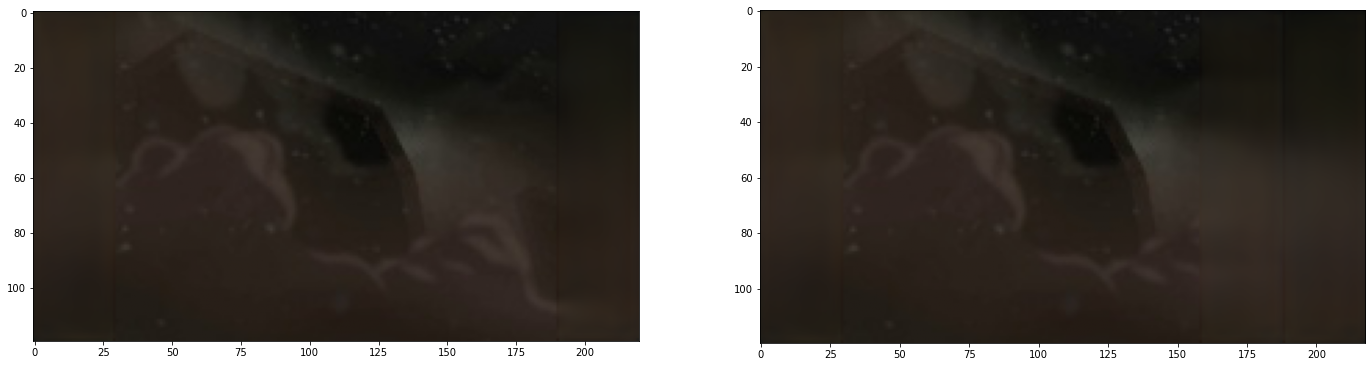

In [20]:
random_names = os.listdir(data_dir)
image_name = random_names[random.randint(0, len(random_names))]
image_true = (1/255.) * np.array(pyplot.imread(os.path.join(data_dir, image_name)), dtype=float)
image = image_true[:,:128,:]

for i in range(2):
    image_x = image[:,-120:,:]
    image_y_pred = u2(np.expand_dims(image_x,axis=0))[-1]
    print(image_y_pred.shape)
    image = np.concatenate((image, image_y_pred[0]), axis=1)

image_x_flip = np.flip(image[:,:120,:], axis=1)
image_y_pred_flip = u2(np.expand_dims(image_x_flip,axis=0))[-1]
image_y_pred_flip = np.flip(image_y_pred_flip[0], axis=1)
image = np.concatenate((image_y_pred_flip, image), axis=1)

image_right = u2(np.expand_dims(image_true[:,-120:,:],axis=0))[-1]
image_true = np.concatenate((image_true, image_right[0]), axis=1)
image_true = np.concatenate((image_y_pred_flip, image_true), axis=1)

plt.figure(figsize=(128, 128))
ax = plt.subplot(10, 10, 1)
plt.imshow(image_true)
ax = plt.subplot(10, 10, 2)
plt.imshow(image)